## Constructing the data set and exporting

In [ ]:
# generate the data
import pandas as pd
# all the names that fit this name
csv_files = glob.glob("./data/song_v*.csv")

# empty list for the data frames
dfs = []
for filename in csv_files:
    df = pd.read_csv(filename, index_col=0)
    dfs.append(df)

# combinar todos los DataFrames en un solo DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

combined_df.to_csv("./data/song_combined_df.csv",)

# imprimir el DataFrame combinado
print(f"ammount of data so far: {len(combined_df)}")
combined_df.tail()

## NN Velocity dependent force
Combining the components into a working Neural Network

In [1]:
from diffnet import F_function, W_matrix, diffNet, smooth_loss, physics_constrain, plot_f
import torch
import torch.nn as nn

import pandas as pd
import glob
import matplotlib.pyplot as plt

combined_df = pd.read_csv("./data/song_combined_df.csv", index_col=0)

print("max speed in data:", combined_df['v_step20'].max())

combined_df.head()


max speed in data: 254.1388364409117


,x_initial,v_initial,x_step10,v_step10,x_step20,v_step20,x_step30,v_step30,x_step40,v_step40,x_step50,v_step50
0,0.000000,10.000000,0.100167,10.033460,0.200670,10.067033,0.301508,10.100719,0.402684,10.134518,0.504199,10.168430
1,0.010002,10.003341,0.110202,10.036813,0.210738,10.070397,0.311611,10.104094,0.412821,10.137904,0.514369,10.171828
2,0.020007,10.006683,0.120241,10.040166,0.220810,10.073761,0.321716,10.107470,0.422960,10.141291,0.524543,10.175226
3,0.030015,10.010026,0.130283,10.043520,0.230886,10.077127,0.331826,10.110847,0.433103,10.144680,0.534720,10.178626
4,0.040027,10.013371,0.140328,10.046876,0.240965,10.080494,0.341938,10.114225,0.443250,10.148069,0.544900,10.182027


In [6]:
# separate input and target:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, combined_df):
        self.combined_df = combined_df
    
    def __len__(self):
        return len(self.combined_df)
    
    def __getitem__(self, idx):
        x_initial = self.combined_df.iloc[idx]['x_initial']
        v_initial = self.combined_df.iloc[idx]['v_initial']
        x_step20 = self.combined_df.iloc[idx]['x_step50']
        v_step20 = self.combined_df.iloc[idx]['v_step50']
        return torch.tensor([x_initial, v_initial], dtype=torch.float32), torch.tensor([x_step20, v_step20], dtype=torch.float32)

my_dataset = MyDataset(combined_df)
my_dataloader = DataLoader(my_dataset, batch_size=32, shuffle=True)

In [7]:
#constructing the network
model = diffNet(depth=50)

In [8]:
for paramA in model.parameters():
    print(len(paramA)) # access every force parameter at each layer
    # but we are getting extra parameters, because it is regenerating

257


In [9]:
# how our loss functions looks for the model activation function
# smooth_loss(force_params)
# physics_constrain(force_params)

smooth_rate = 0.03
constrain_rate = 1.0 # F(v=0) = 0
# L2_loss = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.03)

In [10]:
total_loss = smooth_rate * smooth_loss(list(model.parameters())[0]) +\
    constrain_rate* physics_constrain(list(model.parameters())[0])
    
# backward propagation
total_loss

tensor(1.3726, grad_fn=<AddBackward0>)

tensor(0.9650, grad_fn=<AddBackward0>)
tensor(0.7493, grad_fn=<AddBackward0>)
tensor(0.5915, grad_fn=<AddBackward0>)
tensor(0.4722, grad_fn=<AddBackward0>)


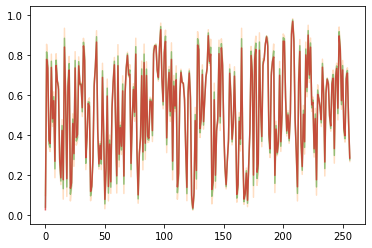

In [11]:
num_epochs = 100

for i in range(num_epochs):
    total_loss = smooth_rate * smooth_loss(list(model.parameters())[0]) +\
        constrain_rate* physics_constrain(list(model.parameters())[0])
        
    # backward propagation
    if (i+1) % 25 == 0:
        print(total_loss)

    total_loss.backward()
    optimizer.step()

    if (i) % 25 == 0:
        plt.plot(list(model.parameters())[0].detach(), alpha = i/num_epochs )

    optimizer.zero_grad()

In [ ]:
# Hyperparameters
smooth_rate = 0.03
constrain_rate = 1.0 # F(v=0) = 0
targets_rate = 0.3

# Define number of epochs
num_epochs = 10

# Define loss function and optimizer
L2_loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.04)

running_loss = 0

#used for graphs
max_i = len(my_dataloader)

# Iterate through epochs
for epoch in range(num_epochs):
    # Iterate through data in the DataLoader
    for i, data in enumerate(my_dataloader, 0):
        # Get inputs and targets from data
        inputs, targets = data
            #x_initial, v_initial = inputs
            #x_step20, v_step20 = targets
        #print(f"maximum velocity in data {inputs[:,1].max()}")

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model.forward(inputs)

        # Compute loss
        loss = smooth_rate * smooth_loss(list(model.parameters())[0]) +\
            constrain_rate*physics_constrain(list(model.parameters())[0]) + targets_rate * L2_loss(outputs, targets)


        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print("L2_loss:", L2_loss(outputs, targets))
            print('[Epoch %d, Mini-batch %5d] Loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    
    if epoch % 5 == 0:
        plt.plot(list(model.parameters())[0].detach(), alpha = epoch/num_epochs)
        plt.show()
        plt.save_fig(f"./evolution_force/epoch_{epoch}.png")

print('Finished training')


In [15]:
# saving the model
torch.save(model, "./model/040223.pt")

In [16]:
# can be loaded using:
model2 = torch.load("./model/040223.pt")

# Loading model and continuum training

In [1]:
from diffnet import F_function, W_matrix, diffNet, smooth_loss, physics_constrain, plot_f
from dataset import MyDataset, DataLoader
import torch
import torch.nn as nn

import pandas as pd
import glob
import matplotlib.pyplot as plt

my_dataset = MyDataset(pd.read_csv("./data/song_combined_df.csv", index_col=0))
my_dataloader = DataLoader(my_dataset, batch_size=32, shuffle=True)

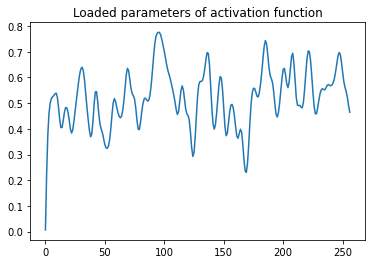

In [2]:
# Loading the model
model = torch.load("./model/040223.pt")

plt.plot(list(model.parameters())[0].detach())
plt.title("Loaded parameters of activation function")
plt.show()

L2_loss: tensor(0.4753, grad_fn=<MseLossBackward0>)
[Epoch 1, Mini-batch   100] Loss: 0.149
L2_loss: tensor(0.4714, grad_fn=<MseLossBackward0>)
[Epoch 1, Mini-batch   200] Loss: 0.147
L2_loss: tensor(0.4503, grad_fn=<MseLossBackward0>)
[Epoch 1, Mini-batch   300] Loss: 0.146
L2_loss: tensor(0.4483, grad_fn=<MseLossBackward0>)
[Epoch 1, Mini-batch   400] Loss: 0.147
L2_loss: tensor(0.4998, grad_fn=<MseLossBackward0>)
[Epoch 1, Mini-batch   500] Loss: 0.149
L2_loss: tensor(0.4882, grad_fn=<MseLossBackward0>)
[Epoch 1, Mini-batch   600] Loss: 0.147
L2_loss: tensor(0.4250, grad_fn=<MseLossBackward0>)
[Epoch 1, Mini-batch   700] Loss: 0.144


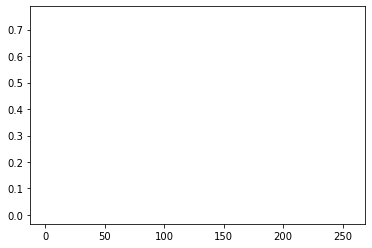

L2_loss: tensor(0.4852, grad_fn=<MseLossBackward0>)
[Epoch 2, Mini-batch   100] Loss: 0.201
L2_loss: tensor(0.4064, grad_fn=<MseLossBackward0>)
[Epoch 2, Mini-batch   200] Loss: 0.142
L2_loss: tensor(0.4143, grad_fn=<MseLossBackward0>)
[Epoch 2, Mini-batch   300] Loss: 0.144
L2_loss: tensor(0.5256, grad_fn=<MseLossBackward0>)
[Epoch 2, Mini-batch   400] Loss: 0.145
L2_loss: tensor(0.5290, grad_fn=<MseLossBackward0>)
[Epoch 2, Mini-batch   500] Loss: 0.144
L2_loss: tensor(0.4191, grad_fn=<MseLossBackward0>)
[Epoch 2, Mini-batch   600] Loss: 0.145


In [3]:
# Hyperparameters
smooth_rate = 0.03
constrain_rate = 1.0 # F(v=0) = 0
targets_rate = 0.3

# Define number of epochs
num_epochs = 10

# Define loss function and optimizer
L2_loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.08)

running_loss = 0

#used for graphs
max_i = len(my_dataloader)

# Iterate through epochs
for epoch in range(num_epochs):
    # Iterate through data in the DataLoader
    for i, data in enumerate(my_dataloader, 0):
        # Get inputs and targets from data
        inputs, targets = data
            #x_initial, v_initial = inputs
            #x_step20, v_step20 = targets
        #print(f"maximum velocity in data {inputs[:,1].max()}")

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model.forward(inputs)

        # Compute loss
        loss = smooth_rate * smooth_loss(list(model.parameters())[0]) +\
            constrain_rate*physics_constrain(list(model.parameters())[0]) + targets_rate * L2_loss(outputs, targets)


        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print("L2_loss:", L2_loss(outputs, targets))
            print('[Epoch %d, Mini-batch %5d] Loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    
    if epoch % 100 == 0:
        # saving the model
        torch.save(model, f"./model/song_040223_epoch{epoch}.pt")
        
        #ploting
        plt.plot(list(model.parameters())[0].detach(), alpha = epoch/num_epochs)
        plt.show()
        plt.savefig(f"./evolution_force/song_epoch_{epoch}_loss_{running_loss :.2f}.png")

print('Finished training')

In [ ]:
# saving the model
torch.save(model, f"./model/song_040223_epoch{epoch}.pt")